The EDEX modelsounding plugin creates 64-level vertical profiles from GFS and ETA (NAM) BUFR products distirubted over NOAAport. Paramters which are requestable are **pressure**, **temperature**, **specHum**, **uComp**, **vComp**, **omega**, **cldCvr**.

In [1]:
from awips.dataaccess import DataAccessLayer
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import exp, log
import numpy as np
from metpy.calc import get_wind_components, lcl, dry_lapse, parcel_profile, dewpoint
from metpy.calc import wind_speed, wind_direction, thermo, vapor_pressure
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate

DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("modelsounding")
forecastModel = "GFS"
request.addIdentifier("reportType", forecastModel)
request.setParameters("pressure","temperature","specHum","uComp","vComp","omega","cldCvr")

## Available Locations

In [2]:
locations = DataAccessLayer.getAvailableLocationNames(request)
locations.sort()
list(locations)

[b'',
 b'1V4',
 b'3J2',
 b'4BL',
 b'4BQ',
 b'4HV',
 b'4OM',
 b'5AF',
 b'5AG',
 b'5SZ',
 b'6RO',
 b'8V7',
 b'9B6',
 b'A#2',
 b'A#3',
 b'A#4',
 b'A#5',
 b'A#6',
 b'A#7',
 b'A#8',
 b'A#9',
 b'A#A',
 b'A#B',
 b'ABL',
 b'ADM',
 b'AFA',
 b'AGR',
 b'AHN',
 b'AIA',
 b'AIH',
 b'AJO',
 b'ANJ',
 b'APX',
 b'AQQ',
 b'ATH',
 b'ATL1',
 b'ATL2',
 b'ATL3',
 b'ATL4',
 b'ATLH',
 b'AWH',
 b'AWR',
 b'B#1',
 b'B#2',
 b'B#3',
 b'B#4',
 b'B#5',
 b'B#6',
 b'B#7',
 b'B#8',
 b'B#9',
 b'B#A',
 b'B#B',
 b'B#C',
 b'B#D',
 b'B#E',
 b'B#F',
 b'B#G',
 b'B#H',
 b'B#J',
 b'B#K',
 b'B#L',
 b'B#M',
 b'B#N',
 b'B#O',
 b'B#P',
 b'B#Q',
 b'B#S',
 b'BAB',
 b'BDG',
 b'BDP',
 b'BFL',
 b'BGTL',
 b'BH1',
 b'BH2',
 b'BH3',
 b'BH4',
 b'BH5',
 b'BHK',
 b'BID',
 b'BIR',
 b'BLS',
 b'BLU',
 b'BMX',
 b'BNA',
 b'BOD',
 b'BRA',
 b'BTL',
 b'BVR',
 b'C01',
 b'C02',
 b'C03',
 b'C04',
 b'C06',
 b'C07',
 b'C08',
 b'C09',
 b'C10',
 b'C11',
 b'C12',
 b'C13',
 b'C14',
 b'C17',
 b'C18',
 b'C19',
 b'C20',
 b'C21',
 b'C22',
 b'C23',
 b'C24',
 b'C25'

In [3]:
request.setLocationNames("KFRM")
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)

try:
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)
    list(fcstRun)
    response = DataAccessLayer.getGeometryData(request,[fcstRun[0]])
except:
    print('No times available')
    exit

## Model Sounding Parameters

Construct arrays for each parameter to plot (temperature, pressure, moisutre (spec. humidity), wind components, and cloud cover)

In [5]:
tmp,prs,sh = np.array([]),np.array([]),np.array([])
uc,vc,om,cld = np.array([]),np.array([]),np.array([]),np.array([])

for ob in response:
    tmp = np.append(tmp,ob.getNumber("temperature"))
    prs = np.append(prs,ob.getNumber("pressure"))
    sh = np.append(sh,ob.getNumber("specHum"))
    uc = np.append(uc,ob.getNumber("uComp"))
    vc = np.append(vc,ob.getNumber("vComp"))
    om = np.append(om,ob.getNumber("omega"))
    cld = np.append(cld,ob.getNumber("cldCvr"))

print("parms    = " + str(ob.getParameters()))
print("site     = " + str(ob.getLocationName()))
print("geom     = " + str(ob.getGeometry()))
print("datetime = " + str(ob.getDataTime()))
print("reftime  = " + str(ob.getDataTime().getRefTime()))
print("fcstHour = " + str(ob.getDataTime().getFcstTime()))
print("period   = " + str(ob.getDataTime().getValidPeriod()))

parms    = [b'temperature', b'pressure', b'vComp', b'uComp', b'cldCvr', b'specHum', b'omega']
site     = b'KFRM'
geom     = POINT (-94.41999816894531 43.65000152587891)
datetime = 2018-10-05 12:00:00
reftime  = Oct 05 18 12:00:00 GMT
fcstHour = 0
period   = (Oct 05 18 12:00:00 , Oct 05 18 12:00:00 )


## Calculating Dewpoint from Specific Humidity

Because the modelsounding plugin does not return dewpoint values, we must calculate the profile ourselves.  Here are three examples of dewpoint calculated from specific humidity, including a manual calculation following NCEP AWIPS/NSHARP. 

**1) MetPy calculated mixing ratio and vapor pressure**

In [6]:
t = (tmp-273.15) * units.degC
p = prs/100 * units.mbar

u,v = uc*1.94384,vc*1.94384 # m/s to knots
spd = wind_speed(u, v) * units.knots
dir = wind_direction(u, v) * units.deg

In [8]:
rmix = (sh/(1-sh)) *1000 * units('g/kg')
e = vapor_pressure(p, rmix)
td = dewpoint(e)

**2) metpy calculated assuming spec. humidity = mixing ratio**

In [9]:
td2 = dewpoint(vapor_pressure(p, sh))

**3) NCEP AWIPS soundingrequest plugin**

based on GEMPAK/NSHARP, from https://github.com/Unidata/awips2-ncep/blob/unidata_16.2.2/edex/gov.noaa.nws.ncep.edex.plugin.soundingrequest/src/gov/noaa/nws/ncep/edex/plugin/soundingrequest/handler/MergeSounding.java#L1783

In [11]:
# new arrays
ntmp = tmp

# where p=pressure(pa), T=temp(C), T0=reference temp(273.16)
rh = 0.263*prs*sh / (np.exp(17.67*ntmp/(ntmp+273.15-29.65)))
vaps =  6.112 * np.exp((17.67 * ntmp) / (ntmp + 243.5))
vapr = rh * vaps / 100
dwpc = np.array(243.5 * (np.log(6.112) - np.log(vapr)) / (np.log(vapr) - np.log(6.112) - 17.67)) * units.degC

/Users/mjames/miniconda3/envs/python3-awips/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/mjames/miniconda3/envs/python3-awips/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## MetPy SkewT and Hodograph

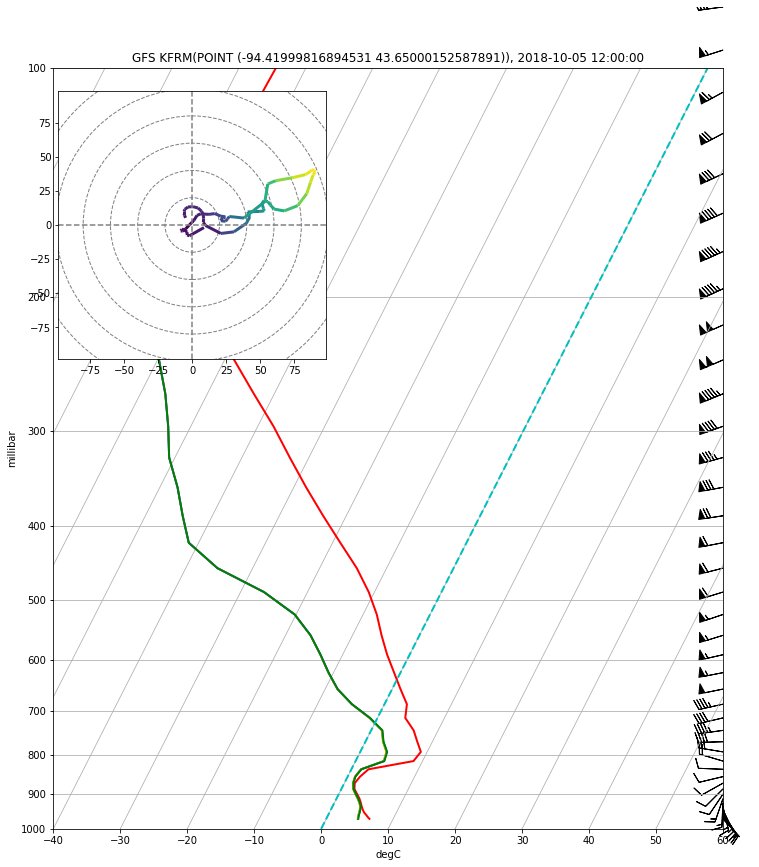

In [12]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 14)

# Create a skewT plot
skew = SkewT()

# Plot the data
skew.plot(p, t, 'r', linewidth=2)
skew.plot(p, td, 'b', linewidth=2)
skew.plot(p, td2, 'y')
skew.plot(p, dwpc, 'g', linewidth=2)

skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

plt.title( forecastModel + " " \
          + ob.getLocationName().decode('UTF-8') \
          + "("+ str(ob.getGeometry()) + ")" \
          + ", " + str(ob.getDataTime())
)

# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
h = Hodograph(ax_hod, component_range=wind_speed(u, v).max())
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()